## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
os.environ['XLA_FLAGS'] = "--xla_disable_hlo_passes=constant_folding"
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jaxquantum.codes as jqtb
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import numpy as np
from jax_tqdm import scan_tqdm
from jaxopt import GaussNewton
from sbs import sbs
plt.style.use('ggplot')

/home/rolleri/.conda/envs/jax-sims/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check CUDA devs

In [3]:
jax.devices()

[CudaDevice(id=0)]

In [4]:
jax.devices()[0]

CudaDevice(id=0)

In [5]:
jax.devices()[0].memory_stats()

## Declare circuit parameters

In [6]:
N = 120
T = 15

t_sqg = 56 #ns
t_reset = 348 #ns

In [7]:
linear_betas = np.load("cd_delay_times.npz", allow_pickle = True)["data"].tolist()[10.5]["betas"][7:]

In [8]:
linear_delays = np.load("cd_delay_times.npz", allow_pickle = True)["data"].tolist()[10.5]["total_ecd_times"][7:]

In [9]:
p = jnp.polyfit(linear_betas, linear_delays, 1)

## Sweep circuit parameters

In [10]:
delta = 0.438
sd_ratio = 1.857
gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": N})
vac = jqt.basis(2, 0) ^ jqt.basis(N, 0)
plus_Z = jqt.basis(2, 0) ^ gkp_qubit.basis["-x"]
initial_state = plus_Z

logical_Z = gkp_qubit.common_gates["X_0"]
freq_res = 4.138e9
freq_qb = 233e6
k_B = 1.380649e-23
h = 6.62607015e-34
T_res = 40e-3
T_qb = 40e-3
n_bar_qb = 1/(jnp.exp(h*freq_qb/k_B/T_qb)-1)
n_bar_res = 1/(jnp.exp(h*freq_res/k_B/T_res)-1)
error_channels = {
    "resonator": {
        "selfkerr": 0,
        "chi": 17e-6*2*jnp.pi,
        "T1": 140e3,
        "Tphi": 65e3*1e6,
        "n_bar": n_bar_res,
    },
    "fluxonium": {
        "T1": 65e3,
        "Tphi": 11e3,#2*150e3*28e3/(2*150e3-28e3),
        "n_bar": n_bar_qb,
        "reset_p_eg": 0.0783,
        "reset_p_ee": 0.0783,
    } 
}

In [11]:
ts, res = sbs(initial_state = initial_state,
            delta=delta,
            sd_ratio=sd_ratio,
            T=T,
            observable=logical_Z,
            t_sqg = t_sqg,
            t_CD_floor = linear_delays[0],
            t_CD_p = p,
            t_rst=t_reset,
            error_channels=error_channels,
            )

Running for 15 iterations: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 30.58it/s]


In [12]:
def fit_t1(times, amps, guess):
    def exponential(x, x_data, y_data):
        return y_data-x[0]*jnp.exp(x[1]*x_data)
    gn = GaussNewton(residual_fun=exponential)
    gn_sol = gn.run(guess, x_data=times, y_data=amps)
    return gn_sol.params, gn_sol.state.error

In [13]:
fit_res = fit_t1(ts, jnp.abs(res), jnp.array([1., -1/30e3]))
coeff = fit_res[0]
residuals = fit_res[1]
t1 = -1/coeff[1]

In [14]:
ts_exp = jnp.array([ 0.348,  6.004, 11.66 , 17.316, 22.972, 28.628, 34.284, 39.94 ,
         45.596, 51.252, 56.908, 62.564, 68.22 , 73.876, 79.532, 85.188])
val_exp = jnp.array([-3.8400e-01,  2.9080e-01, -2.2180e-01,  1.5670e-01, -1.1705e-01,
          6.7350e-02, -5.7000e-02,  3.0250e-02, -2.1350e-02,  1.5900e-02,
         -1.8900e-02,  1.2000e-02, -1.1400e-02,  3.0000e-04, -1.2500e-03,
          3.4000e-03])

In [15]:
fit_res_exp = fit_t1(ts_exp, jnp.abs(val_exp), jnp.array([1., -1/30e3]))
coeff_exp = fit_res_exp[0]
residuals_exp = fit_res_exp[1]
t1_exp = -1/coeff_exp[1]

/home/rolleri/.conda/envs/jax-sims/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/rolleri/.conda/envs/jax-sims/lib/python3.11/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/rolleri/.conda/envs/jax-sims/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


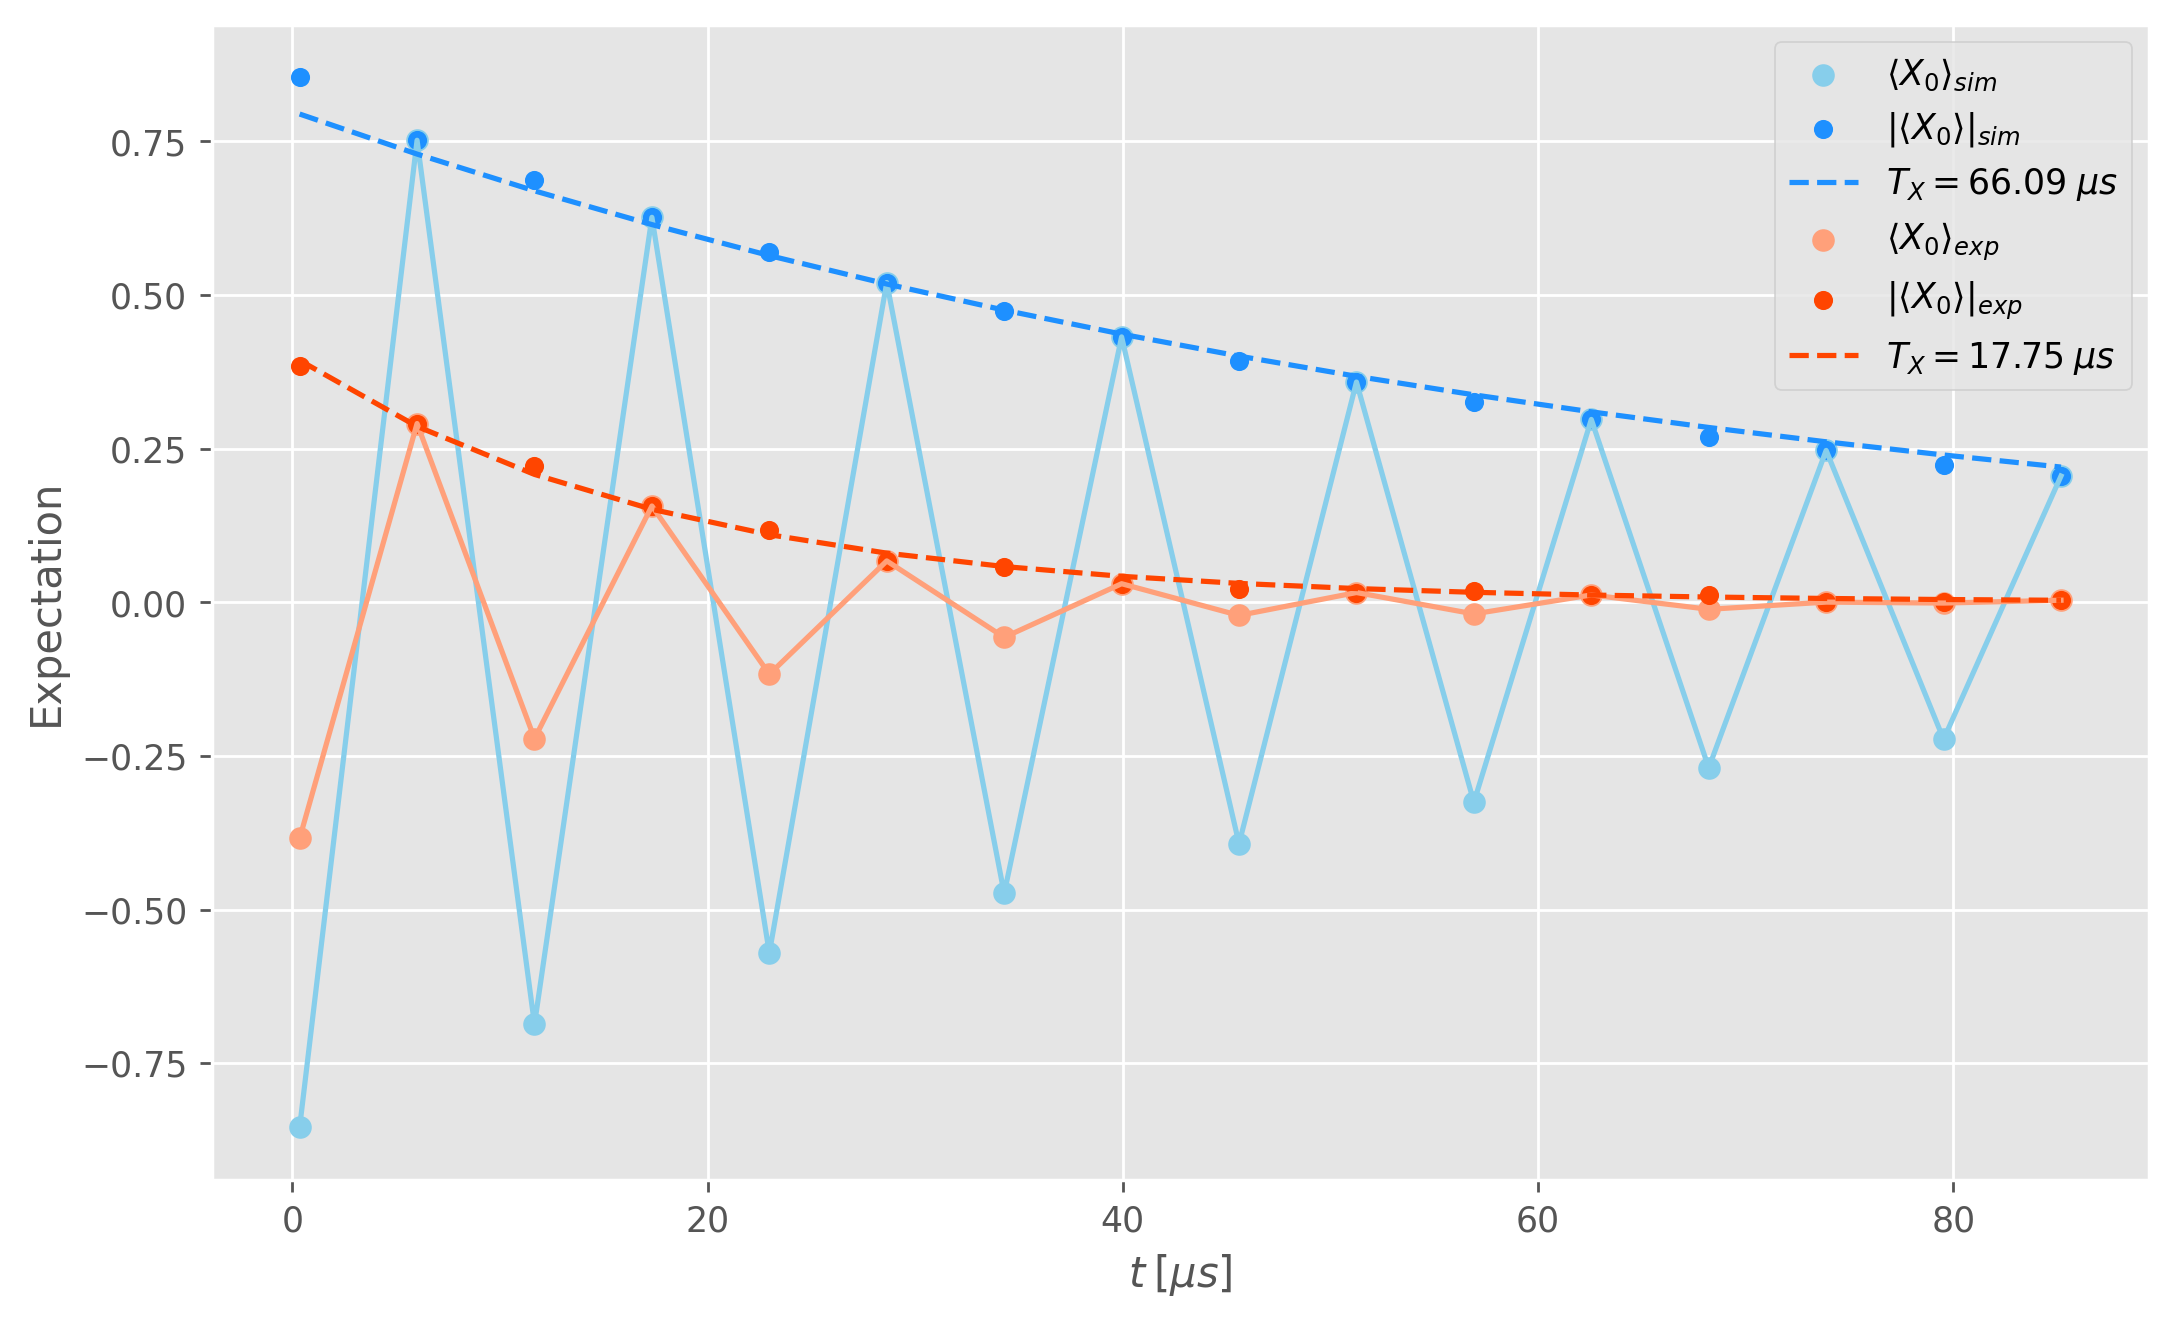

In [16]:
fig, ax = plt.subplots(1, figsize=(10, 6), dpi=250)
ax.scatter(ts/1e3, res, color="skyblue", label="$\\langle X_0 \\rangle_{sim}$")
ax.scatter(ts/1e3, jnp.abs(res), color="dodgerblue", label="$\\vert\\langle X_0 \\rangle\\vert_{sim}$", s=25)

ax.plot(ts/1e3, res, color="skyblue")

fit = coeff[0]*jnp.exp(coeff[1]*ts)
ax.plot(ts/1e3, fit, color="dodgerblue", label=f"$T_X={t1/1e3:.2f} \;\mu s$", ls="--")


ax.scatter(ts_exp, val_exp, color="lightsalmon", label="$\\langle X_0 \\rangle_{exp}$")
ax.scatter(ts_exp, jnp.abs(val_exp), color="orangered", label="$\\vert\\langle X_0 \\rangle\\vert_{exp}$", s=25)
ax.plot(ts_exp, val_exp, color="lightsalmon")
fit_exp = coeff_exp[0]*jnp.exp(coeff_exp[1]*ts_exp)
ax.plot(ts_exp, fit_exp, color="orangered", label=f"$T_X={t1_exp:.2f} \;\mu s$", ls="--")

ax.set_xlabel("$t\: [\mu s]$")
ax.set_ylabel("Expectation")
ax.legend()